# *Insurance Premium Prediction*

![](http://pioneerinstitute.org/wp-content/uploads/healthcare_costs_scrabble.jpg)

## Problem Statement



> **QUESTION**: ACME Insurance Inc. offers affordable health insurance to thousands of customer all over the United States. As the lead data scientist at ACME, **you're tasked with creating an automated system to estimate the annual medical expenditure for new customers**, using information such as their age, sex, BMI, children, smoking habits and region of residence. 
>
> Estimates from your system will be used to determine the annual insurance premium (amount paid every month) offered to the customer. 
> 
>We have given a CSV file containing verified historical data, consisting of the aforementioned information and the actual medical expenses incurred by over 1300 customers. 

> Dataset source: [Kaggle](https://www.kaggle.com/noordeen/insurance-premium-prediction)
> 

## Loading Libraries

In [2]:
import pandas as pd
import numpy as np
import statsmodels
import warnings
warnings.filterwarnings('ignore')

import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import pickle

In [3]:
# Let us load the dataset
df = pd.read_csv("insurance.csv")

In [4]:
df

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86
...,...,...,...,...,...,...,...
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95


The dataset contains 1338 rows and 7 columns. Each row of the dataset contains information about one customer. 

Our objective is to find a way to estimate the value in the "expenses" column using the values in the other columns. We can do it for the historical data, then we will estimate expenses for new customers, simply by asking for information like their age, sex, BMI, no. of children, smoking habits and region.

Let's check the data type for each column.

In [5]:
# Print the more information about the features
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Looks like "age", "children", "bmi" ([body mass index](https://en.wikipedia.org/wiki/Body_mass_index)) and "expenses" are numbers, whereas "sex", "smoker" and "region" are strings (possibly categories). None of the columns contain any missing values, which saves us a fair bit of work!

Here are some statistics for the numerical columns:

In [6]:
# Let us see statistical information about the Numerical features
df.describe()

,age,bmi,children,expenses
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.665471,1.094918,13270.422414
std,14.049960,6.098382,1.205493,12110.011240
min,18.000000,16.000000,0.000000,1121.870000
25%,27.000000,26.300000,0.000000,4740.287500
50%,39.000000,30.400000,1.000000,9382.030000
75%,51.000000,34.700000,2.000000,16639.915000
max,64.000000,53.100000,5.000000,63770.430000


The ranges of values in the numerical columns seem reasonable too (no negative ages!), so we may not have to do much data cleaning or correction. The "expenses" column seems to be significantly skewed however, as the median (50 percentile) is much lower than the maximum value.


> 1. The range of expenses in the numerical column seems to have lot of difference in 75 percentile and the maximun expenses it looks like outliers. So we will handle that outlierr.
> 2. The range of the bmi in the numerical columns seems to have little difference in 75  percentile and the maximum bmi value.
> 3. Almost 50 percent of the customers have one child.

In [7]:
# Let us see more statiscal information of the categorical features 
df.describe(include="O")

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


## Exploratory Analysis and Visualization

Let's explore the data by visualizing the distribution of values in some columns of the dataset, and the relationships between "expenses" and other columns.

We'll use libraries Matplotlib, Seaborn and Plotly for visualization.


The following settings will improve the default style and font sizes for our charts.

In [8]:
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

### Age

Age is a numeric column. The minimum age in the dataset is 18 and the maximum age is 64. Thus, we can visualize the distribution of age using a histogram with 47 bins (one for each year) and a box plot. We'll use plotly to make the chart interactive, but you can create similar charts using Seaborn.

In [9]:
fig = px.histogram(df, 
                   x='age', 
                   marginal='box', 
                   nbins=47, 
                   title='Distribution of Age')
fig.update_layout(bargap=0.1)
fig.show()

The distribution of ages in the dataset is almost uniform, with 20-30 customers at every age, except for the ages 18 and 19, which seem to have over twice as many customers as other ages.


### Body Mass Index

Let's look at the distribution of BMI (Body Mass Index) of customers, using a histogram and box plot.

In [10]:
fig = px.histogram(df,
                    x='bmi',
                    marginal='box',
                    color_discrete_sequence=['red'],
                    title='Distribustion of BMI (Body Mass Index)')

fig.update_layout(bargap=0.1)
fig.show()

The measurements of body mass index seem to form a [Gaussian distribution](https://en.wikipedia.org/wiki/Normal_distribution) centered around the value 30, with a few outliers towards the right. Here's how BMI values can be interpreted ([source](https://study.com/academy/lesson/what-is-bmi-definition-formula-calculation.html)):

![](https://i.imgur.com/lh23OiY.jpg)


### Expenses

Let's visualize the distribution of "expenses" i.e. the annual medical expenses for customers. This is the column we're trying to predict. Let's also use the categorical column "smoker" to distinguish the expenses for smokers and non-smokers.

In [11]:
fig = px.histogram(df,
                    x='expenses',
                    marginal='box',
                    color='smoker',
                    color_discrete_sequence=['green', 'orange'],
                    title="Annual Medical Expenses")

fig.update_layout(bargap=0.1)
fig.show()                   

We can make the following observations from the above graph:

* For most customers, the annual medical expenses are under 10k. Only a small fraction of customer have higher medical expenses, possibly due to accidents, major illnesses and genetic diseases. The distribution follows a "power law"
* There is a significant difference in medical expenses between smokers and non-smokers. While the median for non-smokers is 7.3k, the median for smokers is close to 35k.


### Charges and Gender 

Let us visualize the distribution of "expenses" with the categorical column "sex" to distinguish the expenses for "male" and "female"

In [12]:
fig = px.histogram(df,
                    x="expenses",
                    marginal="box",
                    color="sex",
                    color_discrete_sequence=["blue", "purple"],
                    title="Annual Medical Expenses by Sex")

fig.update_layout(bargap=0.1)
fig.show()                    

We can make following observation from the graph

* There is a significant difference in expenses between male and female. While the median for male and female is almost same but upper fence for male is 42k, the upper fence for female is close to 28k.

### DIstribution of expenses with Region

Let's visualize the distribution of "expenses" with categorical column "region" to distinguish expenses for southwest, southeast, northwest and northeast.

In [13]:
fig = px.histogram(df,
                    x="expenses",
                    marginal="box",
                    color="region",
                    color_discrete_sequence=["grey", "orange", "green","violet"],
                    title="Annual Medical Expenses by Region")

fig.update_layout(bargap=0.1)
fig.show()                    

We make some obervation from the above graph

* There is significant difference in expenses for southeast, southwest, northeast and northwest. While the median for southwest is 8798 , the median for southeast is close to 9294, the median for northwest is 8965 and median for northeast is 10.05k.
*  And the upper fence for southwest is close to  26k, upper fence for southeast is close to 42k, upper fence for northwest is close to 4230kk and the upper fence for northeast is close to 34k.

### Smoker

Let's visualize the distribution of the "smoker" column (containing values "yes" and "no") using a histogram.

In [14]:
px.histogram(df, x="smoker", color="sex", title="Smoker")

From the above graph we make some observations.

* It appears that 20% of the customers have reported they smoking.
* We can also see that smoking appears a more common habit among males.

In [15]:
px.histogram(df, x="region", color="smoker", title="Region")

In [16]:
px.histogram(df, x="smoker", color="children", title="Smoker Vs Children")

Having looked at individual columns, we can now visualize the relationship between "expenses" (the value we wish to predict) and other columns.

### Age and Charges

Let's visualize the relationship between "age" and "expenses" using a scatter plot. Each point in the scatter plot represents one customer. We'll also use values in the "smoker" column to color the points.

In [17]:
fig = px.scatter(df,
                x="age",
                y="expenses",
                color="smoker",
                opacity=0.8,
                hover_data=["sex"],
                width=800,
                height=500,
                title="Age vs Expenses")

fig.update_traces(marker_size=5)
fig.show()                

We can make the following observations from the above chart:

* The general trend seems to be that medical expenses increase with age, as we might expect. However, there is significant variation at every age, and it's clear that age alone cannot be used to accurately determine medical expenses.


* We can see three "clusters" of points, each of which seems to form a line with an increasing slope:

     1. The first and the largest cluster consists primary of presumably "healthy non-smokers" who have relatively low medical expenses compared to others
     
     2. The second cluster contains a mix of smokers and non-smokers. It's possible that these are actually two distinct but overlapping clusters: "non-smokers with medical issues" and "smokers without major medical issues".
     
     3. The final cluster consists exclusively of smokers, presumably smokers with major medical issues that are possibly related to or worsened by smoking.
     


### BMI and Expenses

Let's visualize the relationship between BMI (body mass index) and expenses using another scatter plot. Once again, we'll use the values from the "smoker" column to color the points.

In [18]:
fig = px.scatter(df,
                x="bmi",
                y="expenses",
                color="smoker",
                hover_data=['sex'],
                opacity=0.8,
                width=800,
                height=500,
                title="BMI Vs Expenses")

fig.update_traces(marker_size=5)
fig.show()                

It appears that for non-smokers, an increase in BMI doesn't seem to be related to an increase in medical expenses. However, medical expenses seem to be significantly higher for smokers with a BMI greater than 30.


In [19]:
fig = px.scatter(df,
                x="bmi",
                y="expenses",
                color="smoker",
                hover_data=['region'],
                opacity=0.9,
                width=800,
                height=500,
                title= "BMI Vs Expenses")

fig.update_traces(marker_size=5)
fig.show()               

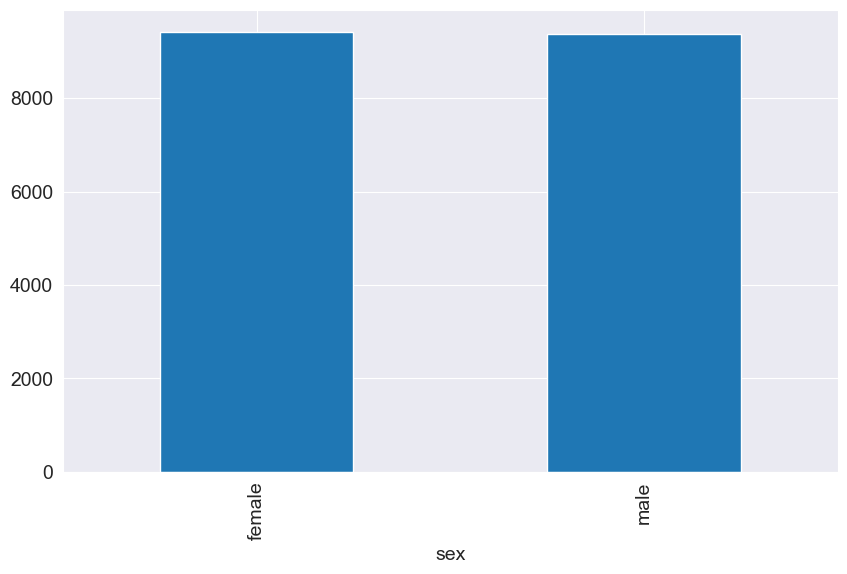

In [20]:
df.groupby("sex")['expenses'].median().plot.bar()
plt.show()

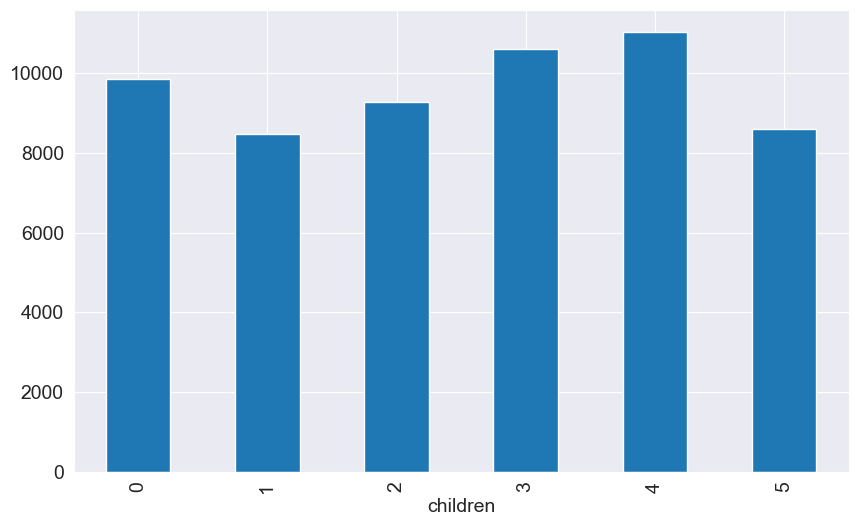

In [21]:
df.groupby("children")['expenses'].median().plot.bar()
plt.show()

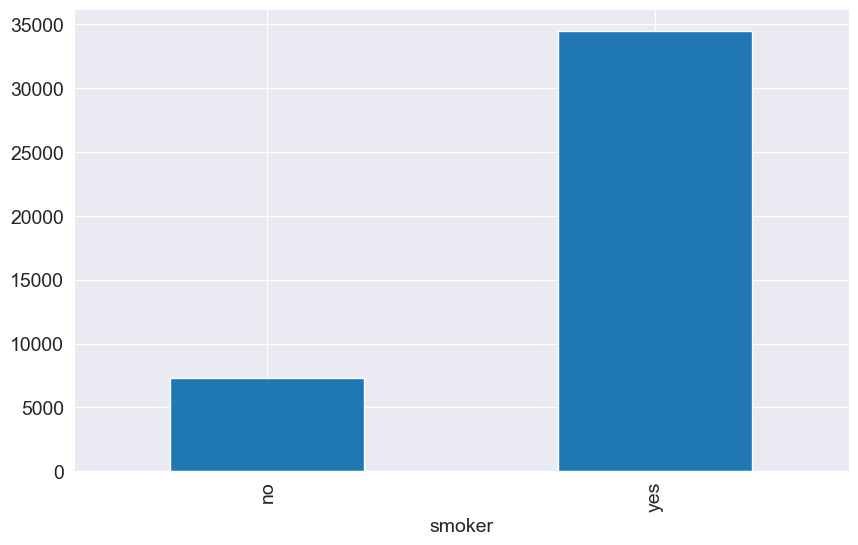

In [22]:
df.groupby("smoker")['expenses'].median().plot.bar()
plt.show()

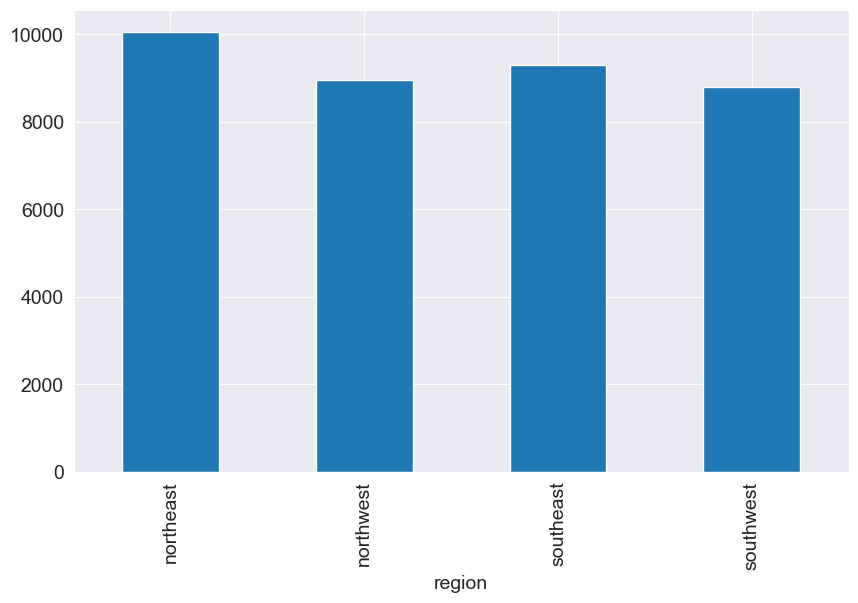

In [23]:
df.groupby("region")['expenses'].median().plot.bar()
plt.show()

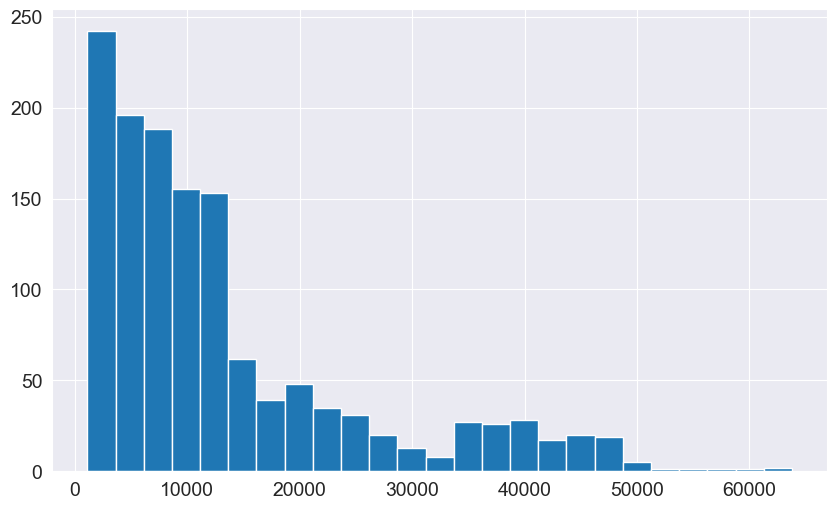

In [24]:
df['expenses'].hist(bins=25)
plt.show()

In [25]:
fig = px.histogram(data_frame=df, x='bmi', y='expenses', width=800, height=500, title='Expenses by BMI')
fig.show()

In [26]:
fig = px.histogram(df, x="bmi", y="expenses", color="sex", marginal="rug", hover_data=df.columns)
fig.show()

In [27]:
fig = px.scatter(df, x="bmi", y="expenses", color='sex', facet_col="children")
fig.update_xaxes(matches=None)
fig.show()

In [28]:
fig = px.pie(data_frame=df, names='sex', values='expenses', width=800, height=500, title='Expenses by Gender')
fig.show()

In [29]:
fig = px.scatter(df, x="bmi", y="expenses", color="sex", width=900, height=500, title="Expenses by BMI & Gender")
fig.show()

In [30]:
fig = px.scatter(df, x="bmi", y="expenses", color="smoker", width=900, height=500, title="Expenses by BMI & Smoker")
fig.show()

In [31]:
fig = px.scatter(df, x="bmi", y="expenses", color="region", width=900, height=500, title="Expenses by BMI & Region")
fig.show()

In [32]:
fig = px.violin(df, y="expenses", x= "sex")
fig.show()

From left plot the insurance charge for male and female is approximatley in same range,it is average around 50k.

In [33]:
fig = px.violin(df, y="expenses", x= "smoker")
fig.show()

 In right plot the health expenses for smokers is much wide range compare to non smokers, the average expenses for non smoker is approximately 5000 bucks. For smoker the minimum health expenses is itself 5000 bucks.

In [34]:
fig = px.scatter(df, x="bmi", y="expenses", color="sex", marginal_y="violin",
           marginal_x="box", trendline="ols", template="simple_white")
fig.show()

In [35]:
fig = px.scatter(df, x="bmi", y="expenses", color="smoker", marginal_y="violin",
           marginal_x="box", trendline="ols", template="simple_white")
fig.show()

In [36]:
fig = px.scatter(df, x="bmi", y="expenses", color="region", marginal_y="violin",
           marginal_x="box", trendline="ols", template="simple_white")
fig.show()

In [37]:
fig = px.box(df, x="children", y="expenses", color="smoker", notched=True, title= "Expenses by Children & Smoker")
fig.show()

### Correlation

In [38]:
df_encoded = pd.get_dummies(df, drop_first=True)
df_encoded.corr()


,age,bmi,children,expenses,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
age,1.000000,0.109341,0.042469,0.299008,-0.020856,-0.025019,-0.000407,-0.011642,0.010016
bmi,0.109341,1.000000,0.012645,0.198576,0.046380,0.003968,-0.135992,0.270144,-0.006398
children,0.042469,0.012645,1.000000,0.067998,0.017163,0.007673,0.024806,-0.023066,0.021914
expenses,0.299008,0.198576,0.067998,1.000000,0.057292,0.787251,-0.039905,0.073982,-0.043210
sex_male,-0.020856,0.046380,0.017163,0.057292,1.000000,0.076185,-0.011156,0.017117,-0.004184
smoker_yes,-0.025019,0.003968,0.007673,0.787251,0.076185,1.000000,-0.036945,0.068498,-0.036945
region_northwest,-0.000407,-0.135992,0.024806,-0.039905,-0.011156,-0.036945,1.000000,-0.346265,-0.320829
region_southeast,-0.011642,0.270144,-0.023066,0.073982,0.017117,0.068498,-0.346265,1.000000,-0.346265
region_southwest,0.010016,-0.006398,0.021914,-0.043210,-0.004184,-0.036945,-0.320829,-0.346265,1.000000


Text(0.5, 1.0, 'Correlation Matrix')

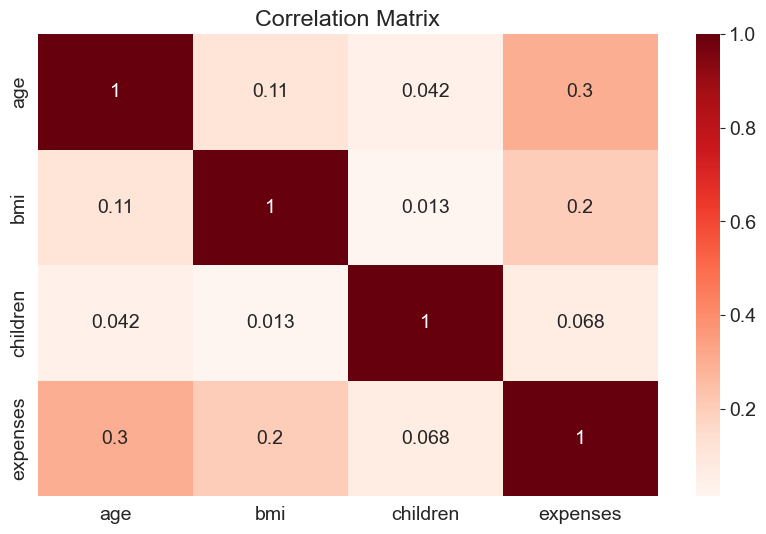

In [39]:
numeric_df = df.select_dtypes(include='number')
sns.heatmap(numeric_df.corr(), cmap='Reds', annot=True)
plt.title('Correlation Matrix')


**Correlation vs causation fallacy:** Note that a high correlation cannot be used to interpret a cause-effect relationship between features. Two features $X$ and $Y$ can be correlated if $X$ causes $Y$ or if $Y$ causes $X$, or if both are caused independently by some other factor $Z$, and the correlation will no longer hold true if one of the cause-effect relationships is broken. It's also possible that $X$ are $Y$ simply appear to be correlated because the sample is too small. 


As you can tell from the analysis, the values in some columns are more closely related to the values in "expenses" compared to other columns. E.g. "age" and "expenses" seem to grow together, whereas "bmi" and "expenses" don't.

This relationship is often expressed numerically using a measure called the _correlation coefficient_, which can be computed using the `.corr` method of a Pandas series.

In [40]:
df.expenses.corr(df.age)

np.float64(0.29900819228508263)

In [41]:
df.expenses.corr(df.bmi)

np.float64(0.198576255018932)

To compute the correlation for categorical columns, they must first be converted into numeric columns.

In [42]:
smoker_values = {'no': 0, 'yes': 1}
smoker_numeric = df.smoker.map(smoker_values)
df.expenses.corr(smoker_numeric)

np.float64(0.7872514298985547)



Here's how correlation coefficients can be interpreted ([source](https://statisticsbyjim.com/basics/correlations)):

* **Strength**: The greater the absolute value of the correlation coefficient, the stronger the relationship.

    * The extreme values of -1 and 1 indicate a perfectly linear relationship where a change in one variable is accompanied by a perfectly consistent change in the other. For these relationships, all of the data points fall on a line. In practice, you won’t see either type of perfect relationship.

    * A coefficient of zero represents no linear relationship. As one variable increases, there is no tendency in the other variable to either increase or decrease.
    
    * When the value is in-between 0 and +1/-1, there is a relationship, but the points don’t all fall on a line. As r approaches -1 or 1, the strength of the relationship increases and the data points tend to fall closer to a line.


* **Direction**: The sign of the correlation coefficient represents the direction of the relationship.

    * Positive coefficients indicate that when the value of one variable increases, the value of the other variable also tends to increase. Positive relationships produce an upward slope on a scatterplot.
    
    * Negative coefficients represent cases when the value of one variable increases, the value of the other variable tends to decrease. Negative relationships produce a downward slope.

Here's the same relationship expressed visually ([source](https://www.cuemath.com/data/how-to-calculate-correlation-coefficient/)):

![]("https://i.imgur.com/3XUpDlw.png")

The correlation coefficient has the following formula:

<img src="https://i.imgur.com/unapugP.png" width="360">

Pandas dataframes also provide a `.corr` method to compute the correlation coefficients between all pairs of numeric columns.

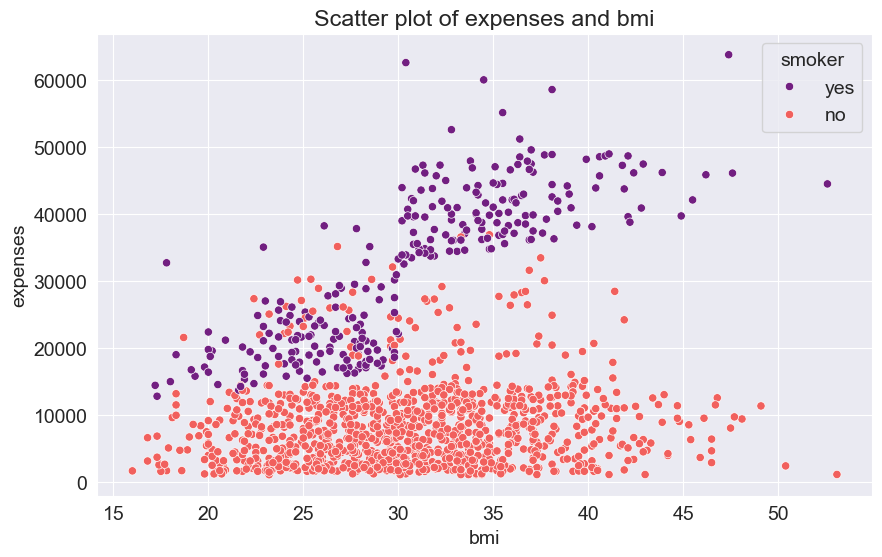

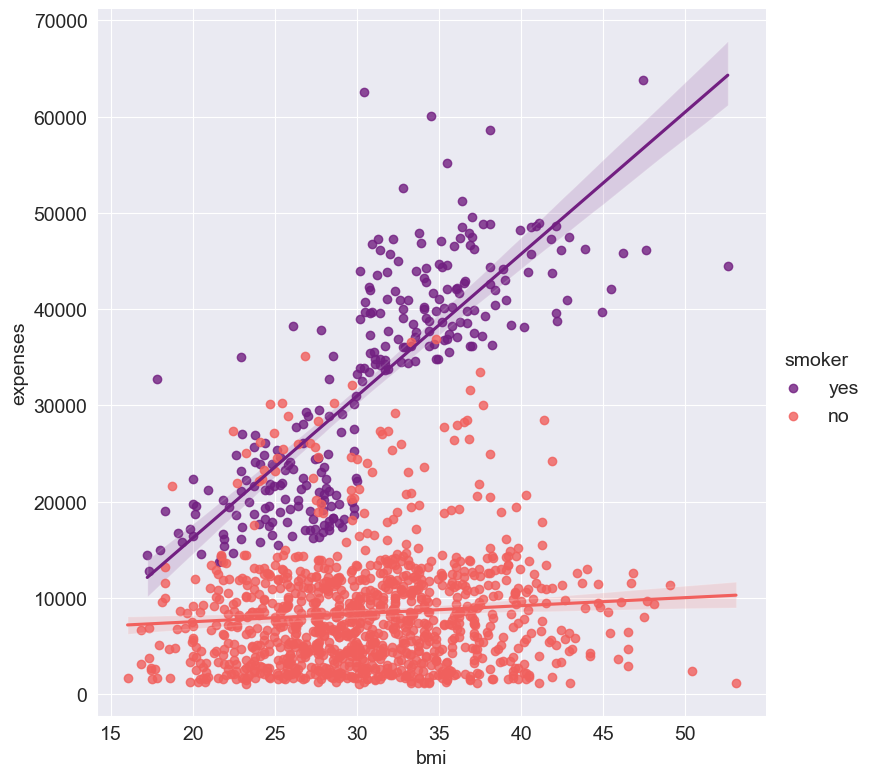

In [43]:
plt.figure(figsize=(10,6))
ax = sns.scatterplot(x='bmi',y='expenses',data=df,palette='magma',hue='smoker')
ax.set_title('Scatter plot of expenses and bmi')

sns.lmplot(x="bmi", y="expenses", hue="smoker", data=df, palette='magma', height=8)



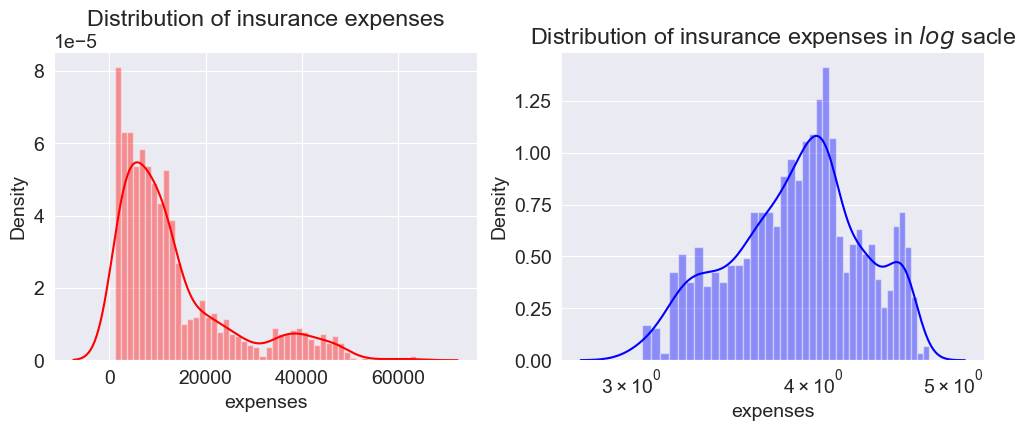

In [45]:
f= plt.figure(figsize=(12,4))

ax=f.add_subplot(121)
sns.distplot(df['expenses'],bins=50,color='r',ax=ax)
ax.set_title('Distribution of insurance expenses')

ax=f.add_subplot(122)
sns.distplot(np.log10(df['expenses']),bins=40,color='b',ax=ax)
ax.set_title('Distribution of insurance expenses in $log$ sacle')
ax.set_xscale('log');


If we look at the left plot the expenses varies from 1120 to 63500, the plot is right skewed. In right plot we will apply natural log, then plot approximately tends to normal. for further analysis we will apply log on target variable charges.

In [46]:
X = df.drop(['expenses'], axis=1)
y = df['expenses']

In [47]:
# Saving the cleaned data
X.to_csv('clean_data.csv')

### Standard Scalar
Standardization of datasets is a common requirement for many machine learning estimators implemented in scikit-learn; they might behave badly if the individual features do not more or less look like standard normally distributed data: Gaussian with zero mean and unit variance.

Standardization is a scaling technique wherein it makes the data scale-free by converting the statistical distribution of the data into the below format:

* mean – 0 (zero)
* standard deviation – 1

<img src="https://www.journaldev.com/wp-content/uploads/2020/10/Standardization.png.webp" width="400">


### One-hot Encoding

The "region" column contains 4 values, so we'll need to use hot encoding and create a new column for each region.

<img src="https://i.imgur.com/n8GuiOO.png" width="500">

In [48]:
# Creating new variables for numerical attributes/columns
numeric_features = ['age', 'bmi', 'children']
# Making pipeline for scaling down numerical features
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# Creating new variables for categorical attributes/columns
categorical_features = ['sex', 'smoker','region']
# MAking pipeling for Encoding categorical features
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Creating new variable for these numerical & categorical features pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


In [49]:
# Splitting the dataset for training and testing the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [50]:
# Let us check shape of the training & test set
print(X_train.shape, y_test.shape)

(1070, 6) (268,)


### Loss/Cost Function

We can compare our model's predictions with the actual targets using the following method:

* Calculate the difference between the targets and predictions (the differenced is called the "residual")
* Square all elements of the difference matrix to remove negative values.
* Calculate the average of the elements in the resulting matrix.
* Take the square root of the result

The result is a single number, known as the **root mean squared error** (RMSE). The above description can be stated mathematically as follows: 

<img src="https://i.imgur.com/WCanPkA.png" width="360">

Geometrically, the residuals can be visualized as follows:

<img src="https://i.imgur.com/ll3NL80.png" width="420">

Let's build a model and evaluate using the RMSE.

## Linear Regression

In [51]:
linear_reg = Pipeline(steps=[('prepocessor', preprocessor), ('linear_regressor', LinearRegression())])

linear_reg.fit(X_train, y_train)

y_pred = linear_reg.predict(X_test)

linear_reg_mse = mean_squared_error(y_test, y_pred)
linear_reg_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
linear_reg_r2_score = r2_score(y_test, y_pred)

# Evaluation Metrics
print("The Mean Squared Error using Linear Regression :{}".format(linear_reg_mse))
print(('The Root Mean Squared Error using Linear Regression :{}'.format(linear_reg_rmse)))
print(('The r2_score using Linear Regression :{}'.format(linear_reg_r2_score)))

The Mean Squared Error using Linear Regression :33600065.355077825
The Root Mean Squared Error using Linear Regression :5796.556335884076
The r2_score using Linear Regression :0.7835726930039906


In [52]:
score = []
for i in range(1000):
    X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2, random_state=i)
    clf = Pipeline(steps=[('preprocessor', preprocessor),('regressor', LinearRegression())])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score.append(r2_score(y_test, y_pred))

In [53]:
np.argmax(score)

np.int64(367)

In [54]:
score[np.argmax(score)]

0.8330631587714106

## Decision Tree

In [55]:
decision_tree = Pipeline(steps=[('preprocessor', preprocessor),
                      ('decision_tree_regressor', DecisionTreeRegressor(max_depth=4, min_samples_split=4,random_state=42 ))])
decision_tree.fit(X_train, y_train)
# Predicting the model
y_pred1 = decision_tree.predict(X_test)
# Evaluation Metrics
decision_tree_mse = mean_squared_error(y_test, y_pred)
decision_tree_rmse = np.sqrt(mean_squared_error(y_test, y_pred1))
decision_tree_r2_score = r2_score(y_test, y_pred1)

print("The Mean Squared Error using Decision Tree Regressor : {}".format(decision_tree_mse))
print("The Root Mean Squared Error using Decision Tree Regressor : {}".format(decision_tree_rmse))
print("The r2_score using Decision Tree Regressor : {}".format(decision_tree_r2_score))

The Mean Squared Error using Decision Tree Regressor : 36656896.05543216
The Root Mean Squared Error using Decision Tree Regressor : 4867.310276315358
The r2_score using Decision Tree Regressor : 0.8387892658296556


## Random Forest

In [56]:
random_forest_reg = Pipeline(steps=[('preprocessor', preprocessor),
                        ('random_forest_regressor', RandomForestRegressor(n_estimators=100, max_depth=4, random_state=42))])
random_forest_reg.fit(X_train, y_train)                        

# Predicting the model
y_pred2 = random_forest_reg.predict(X_test)

# Evaluation Metrics
random_forest_mse = mean_squared_error(y_test, y_pred2)
random_forest_rmse = np.sqrt(mean_squared_error(y_test, y_pred2))
random_forest_r2_score = r2_score(y_test, y_pred2)

print("The Mean Squared Error using Random Forest Regressor : {}".format(random_forest_mse))
print("The Root Mean Squared Error using Random Forest Regressor : {}".format(random_forest_rmse))
print("The r2_score Error using Random Forest Regressor : {}".format(random_forest_r2_score))

The Mean Squared Error using Random Forest Regressor : 22326826.034284692
The Root Mean Squared Error using Random Forest Regressor : 4725.127091865857
The r2_score Error using Random Forest Regressor : 0.8480702300989443


In [57]:
random_forest_reg = Pipeline(steps=[('preprocessor', preprocessor),
                        ('random_forest_regressor', RandomForestRegressor(n_estimators=30, max_depth=4, min_samples_split=5,random_state=42))])
random_forest_reg.fit(X_train, y_train)                        

# Predicting the model
y_pred2 = random_forest_reg.predict(X_test)

# Evaluation Metrics
random_forest_mse = mean_squared_error(y_test, y_pred2)
random_forest_rmse = np.sqrt(mean_squared_error(y_test, y_pred2))
random_forest_r2_score = r2_score(y_test, y_pred2)

print("The Mean Squared Error using Random Forest Regressor : {}".format(random_forest_mse))
print("The Root Mean Squared Error using Random Forest Regressor : {}".format(random_forest_rmse))
print("The r2_score Error using Random Forest Regressor : {}".format(random_forest_r2_score))

The Mean Squared Error using Random Forest Regressor : 22147774.06754165
The Root Mean Squared Error using Random Forest Regressor : 4706.142163974825
The r2_score Error using Random Forest Regressor : 0.8492886443986674


## Gradient Boosting

In [58]:
gradient_boosting_reg = Pipeline(steps=[('preprocessor', preprocessor),
                        ('gradient_boosting' , GradientBoostingRegressor())])

gradient_boosting_reg.fit(X_train, y_train)

# Predicting the model
y_pred3 = gradient_boosting_reg.predict(X_test)

# Evaluation Metrics
gradient_boosting_mse = mean_squared_error(y_test, y_pred3)
gradient_boosting_rmse = np.sqrt(mean_squared_error(y_test, y_pred3))
gradient_boosting_r2_score = r2_score(y_test, y_pred3)

print("The Mean Squared Error using Gradient Boosting Regressor : {}".format(gradient_boosting_mse))
print("The Root Mean Squared Error using Gradient Boosting Regressor : {}".format(gradient_boosting_rmse))
print("The r2_sccore using Gradient Boosting Regressor : {}".format(gradient_boosting_r2_score))

The Mean Squared Error using Gradient Boosting Regressor : 22678654.051708307
The Root Mean Squared Error using Gradient Boosting Regressor : 4762.211046531675
The r2_sccore using Gradient Boosting Regressor : 0.8456761079048701


In [60]:
gradient_boosting_reg = Pipeline(steps=[('preprocessor', preprocessor),
                        ('gradient_boosting' , GradientBoostingRegressor(n_estimators=41, max_depth=3, min_samples_split=4, random_state=42))])

gradient_boosting_reg.fit(X_train, y_train)

# Predicting the model
y_pred3 = gradient_boosting_reg.predict(X_test)

# Evaluation Metrics
gradient_boosting_mse = mean_squared_error(y_test, y_pred3)
gradient_boosting_rmse = np.sqrt(mean_squared_error(y_test, y_pred3))
gradient_boosting_r2_score = r2_score(y_test, y_pred3)

print("The Mean Squared Error using Gradient Boosting Regressor : {}".format(gradient_boosting_mse))
print("The Root Mean Squared Error using Gradient Boosting Regressor : {}".format(gradient_boosting_rmse))
print("The r2_sccore using Gradient Boosting Regressor : {}".format(gradient_boosting_r2_score))

The Mean Squared Error using Gradient Boosting Regressor : 21644204.04957958
The Root Mean Squared Error using Gradient Boosting Regressor : 4652.333183423086
The r2_sccore using Gradient Boosting Regressor : 0.8527153418092427


## KNN

In [61]:
knn = Pipeline(steps=[('preprocessor', preprocessor),
                ('knn', KNeighborsRegressor(n_neighbors=10))])

knn.fit(X_train, y_train)

# Predictiong The model
y_pred4 = knn.predict(X_test)

# Evaluation Metrics
knn_mse = mean_squared_error(y_test, y_pred4)
knn_rmse = np.sqrt(mean_squared_error(y_test, y_pred4))
knn_r2_score = r2_score(y_test, y_pred4)

print("The mean squared error using KNN is {}".format(knn_mse))
print("The root mean squared error using KNN is {}".format(knn_rmse))
print("The r2_score using KNN is {}".format(knn_r2_score))

The mean squared error using KNN is 33407923.373968963
The root mean squared error using KNN is 5779.958769227421
The r2_score using KNN is 0.7726654875491433


## XGBoost

In [62]:
xgb_reg = Pipeline(steps=[('preprocessor', preprocessor),
                ('xgb', xgb.XGBRegressor())])

xgb_reg.fit(X_train, y_train)

# Predicting the moodel
y_pred5 = xgb_reg.predict(X_test)

# Evaluation Metrics
xgb_reg_mse = mean_squared_error(y_test, y_pred5)
xgb_reg_rmse = np.sqrt(mean_squared_error(y_test, y_pred5))
xgb_reg_r2_score = r2_score(y_test, y_pred5)

print("The mean square error using XGBoost is {}".format(xgb_reg_mse))
print("The root mean_squared error using XGBoost is {}".format(xgb_reg_rmse))
print("The r2 score using XGBoost is {}".format(xgb_reg_r2_score))

The mean square error using XGBoost is 33220338.149608932
The root mean_squared error using XGBoost is 5763.708714847492
The r2 score using XGBoost is 0.7739419690306621


Ridge regressor

In [64]:
from sklearn.linear_model import Ridge
ridge_reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('ridge', Ridge(alpha=1.0, random_state=42))  # You can tune alpha as needed
])

# Train the model
ridge_reg.fit(X_train, y_train)

# Predict using the model
y_pred_ridge = ridge_reg.predict(X_test)

# Evaluation Metrics
ridge_mse = mean_squared_error(y_test, y_pred_ridge)
ridge_rmse = np.sqrt(ridge_mse)
ridge_r2_score = r2_score(y_test, y_pred_ridge)

# Print results
print("The Mean Squared Error using Ridge Regressor: {:.2f}".format(ridge_mse))
print("The Root Mean Squared Error using Ridge Regressor: {:.2f}".format(ridge_rmse))
print("The R2 Score using Ridge Regressor: {:.2f}".format(ridge_r2_score))

The Mean Squared Error using Ridge Regressor: 36654678.00
The Root Mean Squared Error using Ridge Regressor: 6054.31
The R2 Score using Ridge Regressor: 0.75


Support Vector Regressor

In [67]:
from sklearn.svm import SVR
svr_reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('svr', SVR(kernel='rbf', C=100, epsilon=0.1))  # You can tune C, epsilon, kernel
])

# Train the model
svr_reg.fit(X_train, y_train)

# Predict using the model
y_pred_svr = svr_reg.predict(X_test)

# Evaluation Metrics
svr_mse = mean_squared_error(y_test, y_pred_svr)
svr_rmse = np.sqrt(svr_mse)
svr_r2_score = r2_score(y_test, y_pred_svr)

# Print results
print("The Mean Squared Error using Support Vector Regressor: {:.2f}".format(svr_mse))
print("The Root Mean Squared Error using Support Vector Regressor: {:.2f}".format(svr_rmse))
print("The R2 Score using Support Vector Regressor: {:.2f}".format(svr_r2_score))

The Mean Squared Error using Support Vector Regressor: 140925499.89
The Root Mean Squared Error using Support Vector Regressor: 11871.20
The R2 Score using Support Vector Regressor: 0.04


In [68]:
models = pd.DataFrame({
    'Model' : ['Linear Regression', 'Decision Tree', 'Random Forest',
               'Gradient Boosting', 'KNN', 'XGBoost','Ridge Regressor','Support Vector Regressor'],
    'RMSE' : [linear_reg_rmse, decision_tree_rmse, random_forest_rmse,
            gradient_boosting_rmse, knn_rmse, xgb_reg_rmse,ridge_rmse,svr_rmse],
    'r2_score' : [linear_reg_r2_score, decision_tree_r2_score, random_forest_r2_score, 
    gradient_boosting_r2_score, knn_r2_score, xgb_reg_r2_score,ridge_r2_score,svr_r2_score]
})

models.sort_values(by='RMSE', ascending=True)

,Model,RMSE,r2_score
3,Gradient Boosting,4652.333183,0.852715
2,Random Forest,4706.142164,0.849289
1,Decision Tree,4867.310276,0.838789
5,XGBoost,5763.708715,0.773942
4,KNN,5779.958769,0.772665
0,Linear Regression,5796.556336,0.783573
6,Ridge Regressor,6054.310695,0.750572
7,Support Vector Regressor,11871.204652,0.041029


From the above observation we can say that the performance (RMSE & R-sqaured) of Gradient boosting model is good as compared to other models. So we will save Gradient boosting model for further testing of the data using pickle library.

In [69]:
pickle.dump(gradient_boosting_reg, open('gradient_boosting_regressor_model.pkl', 'wb'))